### Limma voom analysis of AD/PD dataset, NO SVA, ON PSEUDOREPS 

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(50))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [3]:
##load ATAC-seq raw read counts
data=read.table('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/pseudobulk/count_matrix_overlap/adpd.pseudobulk.overlap.atac.counts.txt.gz',header=TRUE,sep='\t')

##concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$chrom,data$start,data$end,sep="_")
data$chrom=NULL
data$start=NULL
data$end=NULL

data=data[rowSums(data)>0,]


In [4]:
ncol(data)

[1] 24

In [3]:
#load ATAC-seq data normalized counts. These were generated below w/ voom function 
#E=read.table("pr.idr.voom.qnorm.txt",header=TRUE,sep='\t',row.names=1)

In [5]:
#load the metadata
batches=read.table("celltype.csv",header=TRUE,sep='\t')

In [6]:
head(batches)

CellType
<fct>
OPCs
InhibitoryNeurons
InhibitoryNeurons
Astrocytes
Astrocytes
Astrocytes


## Normalize the data with Limma  

In [7]:
tpm=voom(data,normalize.method = "quantile")
E=tpm$E
E=round(E,2)

In [8]:
#save the normalized data so we can load those values directly next time
write.table(E,file="pr.idr.voom.qnorm.txt",quote=FALSE,sep='\t')

## Perform PCA analysis find which covariates account for axes of variation

In [9]:
data.pca=prcomp(t(E))

In [10]:
var_explained=as.character(round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2))


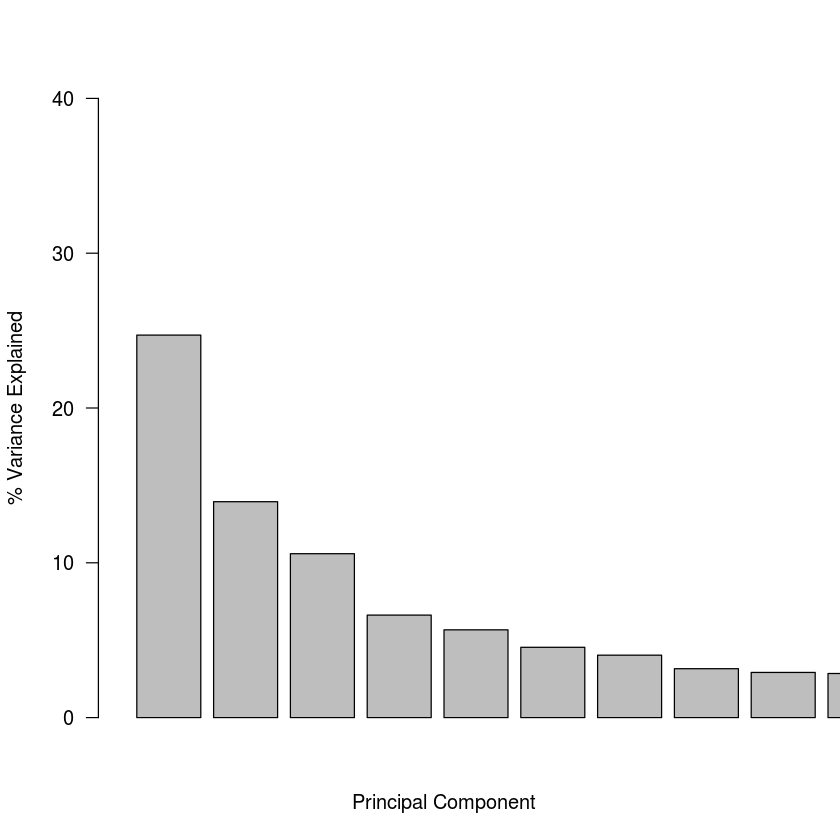

In [11]:
barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,ylab="% Variance Explained",xlab="Principal Component",ylim=c(0,40), xlim=c(0,10))

In [12]:
var_explained[0:10]

[1] "24.71" "13.95" "10.59" "6.62"  "5.67"  "4.54"  "4.03"  "3.16"  "2.92" 
[10] "2.85"

In [13]:
nrow(batches)

[1] 24

In [14]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,CellType
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Cluster10,-233.34902,-147.794973,16.57922,-358.07657,446.15918,-382.33159,46.628781,-7.577562,255.984366,-151.435782,⋯,83.935997,9.613738,21.761843,49.81824193,-13.544112,3.5696414,3.132048e+00,1.272044e+00,-6.072288e-11,OPCs
Cluster11,412.86255,31.921118,237.28454,-425.88357,-95.49215,205.75060,-119.098698,144.862709,-47.648520,-40.224119,⋯,344.117726,-326.320580,52.579058,0.06447876,21.598519,9.4136312,-1.040993e+01,-8.332574e-01,6.019184e-12,InhibitoryNeurons
Cluster12,378.99717,-55.677062,196.09940,-497.01672,30.30146,524.94153,-4.693004,314.927185,2.036142,-33.970171,⋯,-221.036808,227.917608,-17.281521,-7.57084183,6.271631,-1.5835569,3.908405e+00,1.452644e+00,-8.747862e-12,InhibitoryNeurons
Cluster13,-228.45200,-279.339407,-49.21556,215.57428,57.77881,60.73143,-283.652606,-2.560281,46.093504,139.007226,⋯,-244.186729,-167.821462,88.280426,-54.34643942,-16.862374,8.2232467,1.941193e+00,-2.523674e+00,-5.300552e-12,Astrocytes
Cluster14,-54.38240,-461.792000,94.62575,260.68179,-10.17845,-14.24315,-323.928428,1.752237,62.892890,37.356484,⋯,157.405290,211.135273,-71.971204,37.95737663,330.192414,13.2630366,-7.387744e+00,-1.212093e+00,2.127449e-12,Astrocytes
Cluster15,-185.84041,-713.171871,133.06763,128.28513,-145.03832,-19.53677,-262.609519,-4.860151,-24.613903,8.409596,⋯,130.742821,170.100932,141.710938,25.45253190,-325.945342,-3.1205602,3.864756e-01,-2.172480e+00,7.589841e-12,Astrocytes
Cluster16,-150.31062,-756.386063,81.09162,140.21131,-150.59387,27.60043,-21.197061,-23.085859,-133.733481,16.409149,⋯,-142.698110,-265.003638,-114.290559,-44.54956036,55.983444,-6.6325922,8.746212e-03,1.222028e+00,2.703770e-12,Astrocytes
Cluster17,-165.29414,-734.217240,-45.10137,123.00114,-181.46980,44.16578,688.248004,71.583823,111.619394,-104.382756,⋯,59.064775,30.123568,-32.639075,14.25402894,14.866892,-2.3455217,6.209576e+00,4.468009e-01,6.342282e-12,Astrocytes
Cluster18,-479.07883,215.223867,-508.38438,-99.43581,-66.91681,47.46850,141.204443,-26.394692,-195.452511,431.391823,⋯,34.408942,28.830056,25.077741,-12.94188072,-1.091342,10.8686431,2.096603e+00,-3.173213e+00,6.182080e-12,Doublets


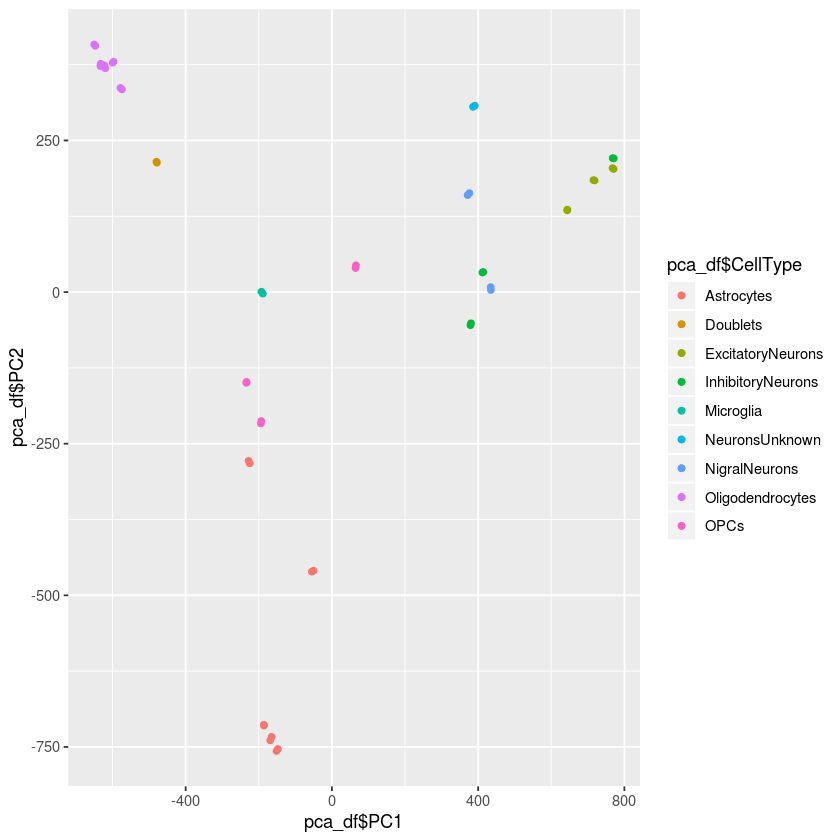

In [15]:
ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$CellType))+
geom_point(position='jitter')+
geom_jitter(width = 5, height = 5)

## Grouping on Cohort, Region, and Type

In [16]:
Grouping <- factor(paste0(batches$CellType))

In [17]:
batches$Grouping=Grouping

In [18]:
colSums(is.na(batches))

CellType Grouping 
       0        0

In [19]:
mod=model.matrix(~Grouping,data=batches)

### fit model with limma 

In [20]:
fit <- lmFit(E,mod)

In [21]:
colnames(mod)


[1] "(Intercept)"               "GroupingDoublets"         
[3] "GroupingExcitatoryNeurons" "GroupingInhibitoryNeurons"
[5] "GroupingMicroglia"         "GroupingNeuronsUnknown"   
[7] "GroupingNigralNeurons"     "GroupingOligodendrocytes" 
[9] "GroupingOPCs"

In [22]:
colnames(fit$coefficients)

[1] "(Intercept)"               "GroupingDoublets"         
[3] "GroupingExcitatoryNeurons" "GroupingInhibitoryNeurons"
[5] "GroupingMicroglia"         "GroupingNeuronsUnknown"   
[7] "GroupingNigralNeurons"     "GroupingOligodendrocytes" 
[9] "GroupingOPCs"

###  Contrasts 

In [24]:
#create contrasts of interest 
cont.matrix=makeContrasts(
    excitatory_vs_inhibitory="GroupingExcitatoryNeurons - GroupingInhibitoryNeurons",
    astro_vs_oligo="(Intercept) - GroupingOligodendrocytes",
    astro_vs_excitatory="(Intercept) - GroupingExcitatoryNeurons",
    astro_vs_inhibitory="(Intercept) - GroupingInhibitoryNeurons",
    astro_vs_microglia="(Intercept) - GroupingMicroglia",
    oligo_vs_excitatory="GroupingOligodendrocytes - GroupingExcitatoryNeurons",
    oligo_vs_inhibitory="GroupingOligodendrocytes - GroupingInhibitoryNeurons",
    oligo_vs_microglia="GroupingOligodendrocytes - GroupingMicroglia",
    opc_vs_excitatory="GroupingOPCs - GroupingExcitatoryNeurons",
    opc_vs_inhibitory="GroupingOPCs - GroupingInhibitoryNeurons",
    opc_vs_oligo="GroupingOPCs - GroupingOligodendrocytes",
    opc_vs_astro="GroupingOPCs - (Intercept)",
    opc_vs_microglia="GroupingOPCs - GroupingMicroglia",
    microglia_vs_excitatory="GroupingMicroglia - GroupingExcitatoryNeurons",
    microglia_vs_inhibitory="GroupingMicroglia - GroupingInhibitoryNeurons",
    levels=mod)

Warning message in makeContrasts(excitatory_vs_inhibitory = "GroupingExcitatoryNeurons - GroupingInhibitoryNeurons", :
“Renaming (Intercept) to Intercept”

In [25]:
fit2=contrasts.fit(fit,cont.matrix)
e=eBayes(fit2)
comparisons=colnames(cont.matrix)

Warning message in contrasts.fit(fit, cont.matrix):
“row names of contrasts don't match col names of coefficients”

In [26]:
pval_thresh=0.05
lfc_thresh=1

In [27]:
for(i in seq(1,length(comparisons)))
{
  tab<-topTable(e, number=nrow(e),coef=i,lfc=lfc_thresh, p.value = pval_thresh)
  up=sum(tab$logFC>0)
  down=sum(tab$logFC<0)
  sig=nrow(tab)
  curtitle=paste(comparisons[i],'\n','sig:',sig,'\n','up:',up,'\n','down:',down,'\n')
  print(curtitle)
  vals=topTable(e,number=nrow(e),coef=i)
  vals$pscaled=-1*log10(vals$adj.P.Val)
  vals$sig=vals$adj.P.Val<pval_thresh & abs(vals$logFC)>lfc_thresh 
  png(paste("pr.volcano_diff",comparisons[i],".png",sep=""))
  print(ggplot(data=vals,
               aes(y=vals$pscaled,x=vals$logFC,color=vals$sig))+
               geom_point(alpha=0.1)+
               xlab("log2(FC)")+
               ylab("-log10(pval)")+
               ggtitle(curtitle)+
               theme_bw()+
               scale_color_manual(values=c("#000000","#FF0000")))
  dev.off() 
  write.table(tab,file=paste("pr.diff_",comparisons[i],".tsv",sep=""),quote=FALSE,sep='\t',row.names = TRUE,col.names = TRUE)
}
    

[1] "excitatory_vs_inhibitory \n sig: 11384 \n up: 9498 \n down: 1886 \n"
[1] "astro_vs_oligo \n sig: 302504 \n up: 86650 \n down: 215854 \n"
[1] "astro_vs_excitatory \n sig: 297694 \n up: 93204 \n down: 204490 \n"
[1] "astro_vs_inhibitory \n sig: 294455 \n up: 88584 \n down: 205871 \n"
[1] "astro_vs_microglia \n sig: 228746 \n up: 81483 \n down: 147263 \n"
[1] "oligo_vs_excitatory \n sig: 223365 \n up: 112984 \n down: 110381 \n"
[1] "oligo_vs_inhibitory \n sig: 179473 \n up: 96227 \n down: 83246 \n"
[1] "oligo_vs_microglia \n sig: 120691 \n up: 60554 \n down: 60137 \n"
[1] "opc_vs_excitatory \n sig: 116408 \n up: 58244 \n down: 58164 \n"
[1] "opc_vs_inhibitory \n sig: 55616 \n up: 35645 \n down: 19971 \n"
[1] "opc_vs_oligo \n sig: 91759 \n up: 41493 \n down: 50266 \n"
[1] "opc_vs_astro \n sig: 259083 \n up: 182564 \n down: 76519 \n"
[1] "opc_vs_microglia \n sig: 87363 \n up: 40511 \n down: 46852 \n"
[1] "microglia_vs_excitatory \n sig: 123300 \n up: 67376 \n down: 55924 \n"
[1] "micro